In [1]:
import keras
import tensorflow as tf
import numpy as np
import tkinter as tk
import matplotlib.pyplot as plt

if tf.config.list_logical_devices("GPU"):
    print("CUDA is available!")
else:
    print("CPU will be used!")


CUDA is available!


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


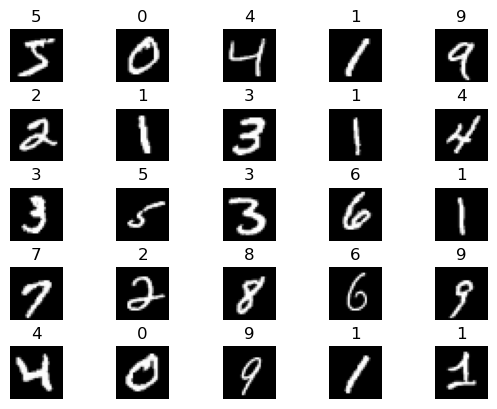

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train, x_test = x_train / 255, x_test / 255 #Нормализуем цифры в диапазоне от 0 до 1
#Отрисовка первых 25 изображений цифр для тренировки
fig, ax = plt.subplots(5,5)
for i, img in enumerate(x_train[:25]):
    axis = ax[i // 5][i % 5]
    axis.imshow(img, cmap="grey")
    axis.set_axis_off()
    axis.set_title(str(y_train[i]))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


In [3]:
#преобразуем numpy array в датасеты, который будет выдавать по 50 изображений за раз с их лейблами
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(50)
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

In [14]:
input = keras.layers.Input(shape=(28,28), name="input")
x = keras.layers.Reshape((28,28,1), input_shape=(28,28), name="reshape")(input)
x1 = keras.layers.Conv2D(2, 3, activation="relu", input_shape=(28,28,1), name="conv2d_1", padding="same")(x)
x2 = keras.layers.MaxPool2D(2,2, name="pool2d_1")(x1)
x3 = keras.layers.Conv2D(4, 3, activation="relu", input_shape=(14,14,2), name="conv2d_2", padding="same")(x2)
x4 = keras.layers.MaxPool2D(2,2, name="pool2d_2")(x3)
x5 = keras.layers.Conv2D(8, 3, activation="relu", input_shape=(7,7,4), name="conv2d_3", padding="same")(x4)
x6 = keras.layers.MaxPool2D(2,2, name="pool2d_3")(x5)
x6 = keras.layers.Dropout(0.5, name="drop_3")(x6)
x6 = keras.layers.Flatten(name="flatten")(x6)
x6 = keras.layers.Dense(128, activation="relu", name="dense_1")(x6)
output = keras.layers.Dense(10, activation="softmax", name="dense_2")(x6)

model = keras.Model(inputs=input, outputs=[x1, x3, x5, output], name="Conv_mnist_model")
model.summary()

Model: "Conv_mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28)]          0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 2)         20        
                                                                 
 pool2d_1 (MaxPooling2D)     (None, 14, 14, 2)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 4)         76        
                                                                 
 pool2d_2 (MaxPooling2D)     (None, 7, 7, 4)           0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 8)      

In [17]:
#можно пропустить этот блок и скачать модель с гитхаб и переместить ее в папку с этим notebook'ом
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001,
                                                             decay_steps=100,
                                                             decay_rate=0.95)


model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule, decay=1e-6),
             loss={"conv2d_1" : None, "conv2d_2" : None, "conv2d_3" : None, "dense_2" : keras.losses.SparseCategoricalCrossentropy()},
             metrics={"conv2d_1" : None, "conv2d_2" : None, "conv2d_3" : None, "dense_2" : keras.metrics.SparseCategoricalAccuracy()})

history = model.fit(dataset_train, validation_data=dataset_test, epochs=100, shuffle=True,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10, verbose=1), 
                               keras.callbacks.ModelCheckpoint("fitted_model.h5", save_best_only=True, verbose=1)], 
                    verbose=1)

Epoch 1/100
1195/1200 [============================>.] - ETA: 0s - loss: 0.8412 - dense_2_loss: 0.8412 - dense_2_sparse_categorical_accuracy: 0.7192
Epoch 1: val_loss improved from inf to 0.25347, saving model to fitted_model.h5
1200/1200 [==============================] - 5s 3ms/step - loss: 0.8398 - dense_2_loss: 0.8398 - dense_2_sparse_categorical_accuracy: 0.7196 - val_loss: 0.2535 - val_dense_2_loss: 0.2535 - val_dense_2_sparse_categorical_accuracy: 0.9211
Epoch 2/100
1196/1200 [============================>.] - ETA: 0s - loss: 0.4922 - dense_2_loss: 0.4922 - dense_2_sparse_categorical_accuracy: 0.8405
Epoch 2: val_loss improved from 0.25347 to 0.20693, saving model to fitted_model.h5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.4922 - dense_2_loss: 0.4922 - dense_2_sparse_categorical_accuracy: 0.8405 - val_loss: 0.2069 - val_dense_2_loss: 0.2069 - val_dense_2_sparse_categorical_accuracy: 0.9382
Epoch 3/100
1191/1200 [============================>.] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


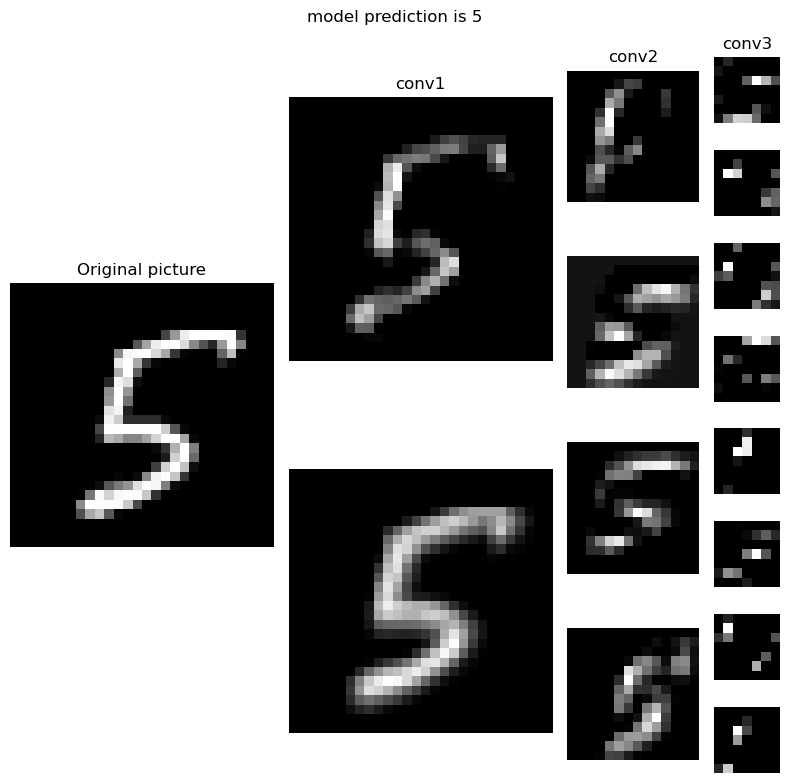

In [19]:
#нарисуем выходы сверточных слоев
model = keras.models.load_model("fitted_model.h5") #можно не запускать обучение и скачать модель на гитхаб
number = x_test[23] #можно выбрать цифру

conv1, conv2, conv3, pred = model.predict(number.reshape(1,28,28))

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8,8))
grid = GridSpec(8, 4, width_ratios=[4,4,2,1])
#Отрисовка оригинального изображения (1 канал серего)
ax = fig.add_subplot(grid[2:6, 0])
ax.imshow(number, cmap="grey")
ax.set_axis_off()
ax.set_title("Original picture")
#Отрисовка выходов первого сверточного слоя (2 фильтра)
ax = fig.add_subplot(grid[:4, 1])
ax.imshow(conv1[0,:,:,0], cmap="grey")
ax.set_axis_off()
ax.set_title("conv1")
ax = fig.add_subplot(grid[4:, 1])
ax.imshow(conv1[0,:,:,1], cmap="grey")
ax.set_axis_off()
#Отрисовка выходов второго сверточного слоя (4 фильтра)
ax = fig.add_subplot(grid[:2, 2])
ax.imshow(conv2[0,:,:,0], cmap="grey")
ax.set_axis_off()
ax.set_title("conv2")
ax = fig.add_subplot(grid[2:4, 2])
ax.imshow(conv2[0,:,:,1], cmap="grey")
ax.set_axis_off()
ax = fig.add_subplot(grid[4:6, 2])
ax.imshow(conv2[0,:,:,2], cmap="grey")
ax.set_axis_off()
ax = fig.add_subplot(grid[6:, 2])
ax.imshow(conv2[0,:,:,3], cmap="grey")
ax.set_axis_off()
#Отрисовка выходов третьего сверточного слоя (8 фильтров)
ax = fig.add_subplot(grid[:1, 3])
ax.imshow(conv3[0,:,:,0], cmap="grey")
ax.set_axis_off()
ax.set_title("conv3")
ax = fig.add_subplot(grid[1:2, 3])
ax.imshow(conv3[0,:,:,1], cmap="grey")
ax.set_axis_off()
ax = fig.add_subplot(grid[2:3, 3])
ax.imshow(conv3[0,:,:,2], cmap="grey")
ax.set_axis_off()
ax = fig.add_subplot(grid[3:4, 3])
ax.imshow(conv3[0,:,:,3], cmap="grey")
ax.set_axis_off()
ax = fig.add_subplot(grid[4:5, 3])
ax.imshow(conv3[0,:,:,4], cmap="grey")
ax.set_axis_off()
ax = fig.add_subplot(grid[5:6, 3])
ax.imshow(conv3[0,:,:,5], cmap="grey")
ax.set_axis_off()
ax = fig.add_subplot(grid[6:7, 3])
ax.imshow(conv3[0,:,:,6], cmap="grey")
ax.set_axis_off()
ax = fig.add_subplot(grid[7:, 3])
ax.imshow(conv3[0,:,:,7], cmap="grey")
ax.set_axis_off()

plt.suptitle("model prediction is {}".format(pred.argmax().item()))
plt.tight_layout()
plt.savefig("test.png")
plt.show()

In [33]:
# Размеры холста и изображения
canvas_size = 280
img_size = 28

from PIL import Image, ImageDraw, ImageOps

class DigitRecognizerApp:
    def __init__(self, root, model):
        self.root = root
        self.model = model
        self.canvas = tk.Canvas(root, width=canvas_size, height=canvas_size, bg='white')
        self.canvas.pack()
        self.button1 = tk.Button(root, text="Предсказать", command=self.predict_digit)
        self.button1.pack()
        self.button2 = tk.Button(root, text="Очистить", command=self.clear)
        self.button2.pack()
        self.canvas.bind("<B1-Motion>", self.draw)
        self.image = Image.new("L", (280, 280), 255)
        self.draw = ImageDraw.Draw(self.image)
        self.label = tk.Label(root, text="", font=("Arial", 16), fg="blue")
        self.label.pack(side="right", padx=10, pady=10)

    def draw(self, event):
        x, y = event.x, event.y
        r = 10  # Радиус кисти
        self.canvas.create_oval(x - r, y - r, x + r, y + r, fill='black')
        self.draw.ellipse([x - r, y - r, x + r, y + r], fill=0)

    def clear(self):
        self.canvas.delete("all")
        self.image = Image.new("L", (280, 280), 255)
        self.draw = ImageDraw.Draw(self.image)

    def predict_digit(self):
        # Сохраняем изображение в формате PNG
        ImageOps.invert(self.image.resize((28, 28))).save("digit.png")

        img = Image.open("digit.png").convert("L")
        img = np.array(img) / 255.0
        img = img.reshape(1, 28, 28)

        # Предсказание цифры
        prediction = self.model.predict(img)[-1]
        self.label.config(text="It is {}".format(prediction.argmax().item()))
        

# Предполагается, что модель уже обучена и загружена
model = tf.keras.models.load_model("fitted_model.h5")  # Замените на ваш путь к модели
root = tk.Tk()
app = DigitRecognizerApp(root, model)
root.mainloop()

1/1 [==============================] - 0s 50ms/step
